In [1]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [2]:
def plot_roc(fpr, tpr, roc_auc, color='darkorange', alpha=1.0, label='', lw=2.5):
    if not label == None and not roc_auc == 0.:
        label = label + '(ROC area = %0.2f)' % roc_auc
    plt.plot(fpr, tpr, color=color, alpha=alpha,
             lw=lw, label=label)
    plt.legend(loc="lower right")

    
def roc_auc_ci(y_true, y_pred, float_precision=2):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    n_bootstraps = 2000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        score = np.round(score, float_precision)
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(round(0.025 * len(sorted_scores)))]
    confidence_upper = sorted_scores[int(round(0.975 * len(sorted_scores)))]
    
    score = roc_auc_score(y_true, y_pred)
    score = np.round(score, float_precision)

    return confidence_lower, score, confidence_upper

### Read data file

In [3]:
df_all = pd.read_csv('./data/data_all.csv')
df_test = pd.read_csv('./data/data_test.csv')
df_dict = {}
for i in range(9):
    df_dict[i] = pd.read_csv('./data/data_readers_{}.csv'.format(i))

### TI-RADS

In [4]:
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)
df_features = df_all_categorical

df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Shape_0', 'Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)

df_features['ID'] = df_all['ID']
test_ids = np.intersect1d(df_all['ID'], df_test['ID'])
df_features = df_features[df_features.ID.isin(test_ids)]
df_features.drop(columns=['ID'], inplace=True)
df_test = df_all[df_all.ID.isin(test_ids)]

w = np.array([[2, 0, 2, 1, 0, 1, 1, 1, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]])

X_test = df_features.as_matrix()

x_cyst = X_test[:, 1]
x_cyst = np.abs(x_cyst - 1)
x_spon = X_test[:, 4]
x_spon = np.abs(x_spon - 1)

X_test = X_test * np.expand_dims(x_cyst, axis=-1)
X_test = X_test * np.expand_dims(x_spon, axis=-1)

y_points_tirads_test = np.dot(X_test, w.T).flatten()

y_true_tirads_test = df_test.Cancer

### Deep learning

In [5]:
df_dl = pd.read_csv('./data/predictions_test.csv')
y_pred_dl_test = df_dl['Prediction'].as_matrix()
y_true_dl_test = df_dl['Cancer'].as_matrix()

### Prediction based on TI-RADS

In [6]:
fpr_dl, tpr_dl, _ = roc_curve(y_true_dl_test, y_pred_dl_test)
roc_auc_dl = roc_auc_ci(y_true_dl_test, y_pred_dl_test)
print('Deep learning: {} [{}; {}]'.format(roc_auc_dl[1], roc_auc_dl[0], roc_auc_dl[2]))
roc_auc_dl = roc_auc_dl[1]

fpr_tirads, tpr_tirads, _ = roc_curve(y_true_tirads_test, y_points_tirads_test)
roc_auc_tirads = roc_auc_ci(y_true_tirads_test, y_points_tirads_test)
print('Expert reader: {} [{}; {}]'.format(roc_auc_tirads[1], roc_auc_tirads[0], roc_auc_tirads[2]))
roc_auc_tirads = roc_auc_tirads[1]

roc_auc_consensus = roc_auc_ci(df_dict[8]['Cancer'].as_matrix(), df_dict[8]['TIRADS points'].as_matrix())
print('Expert consensus: {} [{}; {}]'.format(roc_auc_consensus[1], roc_auc_consensus[0], roc_auc_consensus[2]))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(9):
    fpr_reader, tpr_reader, _ = roc_curve(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['TIRADS points'].as_matrix())
    roc_auc_reader = roc_auc_ci(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['TIRADS points'].as_matrix())
    fpr[i] = fpr_reader
    tpr[i] = tpr_reader
    roc_auc[i] = roc_auc_reader
    if i < 8:
        print('Non-expert reader {}: {}'.format(df_dict[i]['User ID'].as_matrix()[0], np.round(roc_auc[i], 2)))

Deep learning: 0.87 [0.76; 0.95]
Expert reader: 0.91 [0.82; 0.97]
Expert consensus: 0.91 [0.82; 0.97]
Non-expert reader 723: [0.63 0.76 0.88]
Non-expert reader 18: [0.76 0.85 0.94]
Non-expert reader 487: [0.73 0.83 0.92]
Non-expert reader 117: [0.62 0.78 0.92]
Non-expert reader 183: [0.7  0.85 0.97]
Non-expert reader 55: [0.69 0.81 0.91]
Non-expert reader 860: [0.66 0.79 0.91]
Non-expert reader 504: [0.72 0.83 0.92]


### Results analysis

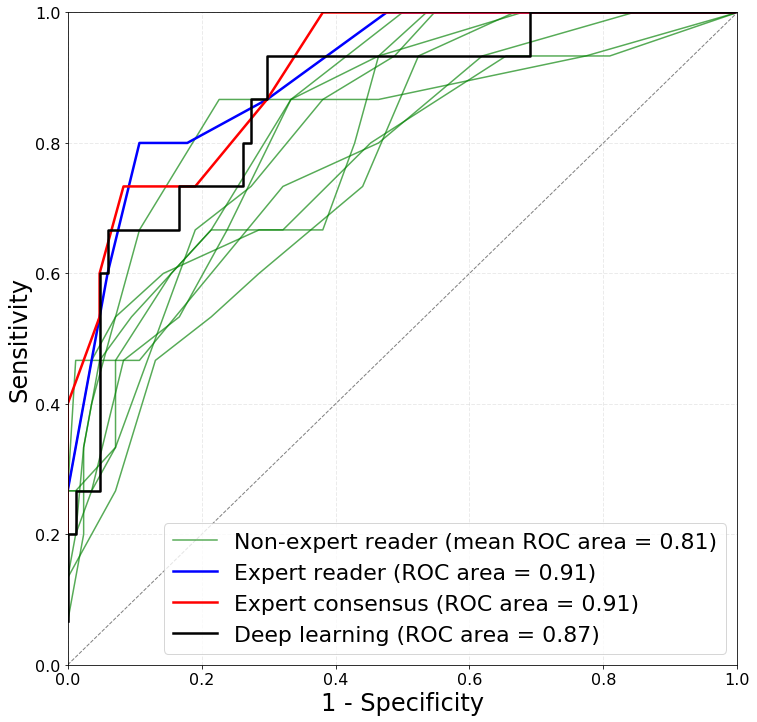

In [19]:
plt.figure(figsize=(12, 12))
colors = ['olive', 'darkseagreen', 'teal', 'orange', 'mediumslateblue', 'orchid', 'palegoldenrod', 'deepskyblue', 'chocolate']
roc_auc_values = [x[1] for x in roc_auc.values()]
for i in range(8):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    label = 'Non-expert reader (mean ROC area = {})'.format(np.round(np.mean(roc_auc_values[:8]), 2))
    color = 'green'
    plot_roc(fpr[i], tpr[i], 0., color=color, alpha=0.66, label=(label if user_id in [723] else None), lw=1.5)
plot_roc(fpr_tirads, tpr_tirads, roc_auc_tirads, color='blue', label='Expert reader ')
plot_roc(fpr[8], tpr[8], roc_auc[8][1], color='red', label='Expert consensus ')
plot_roc(fpr_dl, tpr_dl, roc_auc_dl, color='black', label='Deep learning ')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('', fontsize='xx-large')
plt.xlabel('1 - Specificity', fontsize=24)
plt.ylabel('Sensitivity', fontsize=24)
plt.legend(loc='lower right', fontsize=22)
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)